# Analyse tha thinks

In [57]:
import pandas as pd
from matplotlib import pyplot
import statsmodels.api as sm
import json
import glob

## Defs

In [58]:
agencies = ['kna', 'sda', 'cic', 'kap']
path_in = '../data_cleaned/article/'

## Load files

In [59]:
filelist = glob.glob("%s*.json" % path_in)
records = []
for f in filelist:
    with open(f, encoding='utf-8') as json_file:
        records.append(json.load(json_file))

In [60]:
df = pd.DataFrame(records)
df['date'] = pd.to_datetime(df['date'])

# Analyze

## Articles per day
https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621

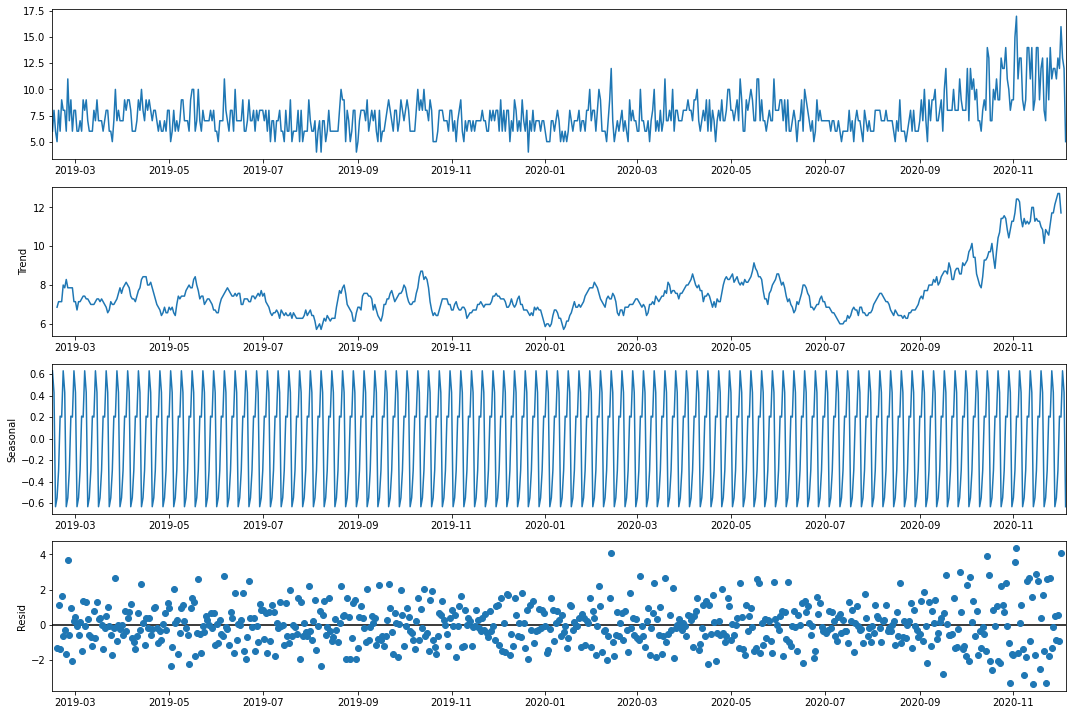

In [61]:
df_data = df.copy()
df_data['_date'] = df_data['date'].dt.date
df_data['_date'] = pd.to_datetime(df_data['_date'])
gr = df_data.groupby('_date').agg({'id': 'count'})#.reset_index()

decomposition = sm.tsa.seasonal_decompose(gr, model = 'additive')
pyplot.rcParams['figure.figsize'] = [15, 10]
fig = decomposition.plot()

## Top Writers
CIC = "Centrum Informationis Catholicum"

<AxesSubplot:xlabel='author'>

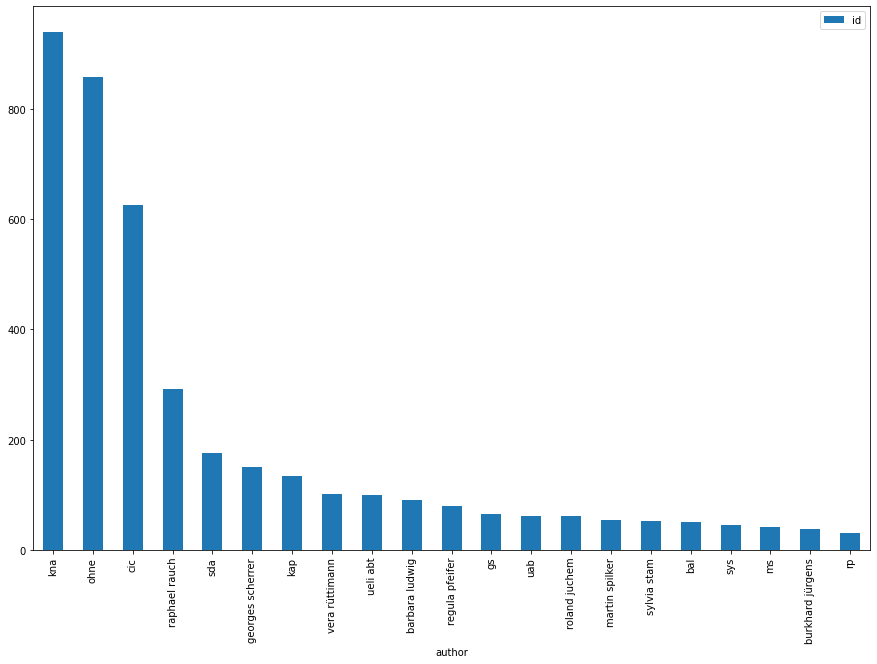

In [62]:
df_data = df.copy()

df_data['author'] = df_data['author'].fillna('ohne')

gr = df_data.groupby(df_data.author.str.lower()).agg({'id': 'count'}).sort_values('id', ascending=False)
gr = gr[gr['id'] >= 30]
gr.plot.bar()

## Writer by time

In [63]:
# Get Top Writers
df_data = df.copy()

df_data['author'] = df_data['author'].fillna('ohne')

df_top = df_data.groupby(df_data.author.str.lower()).agg({'id': 'count'}).sort_values('id', ascending=False)
df_top = df_top[df_top['id'] >= 40]
df_top['top'] = True

<AxesSubplot:xlabel='_date'>

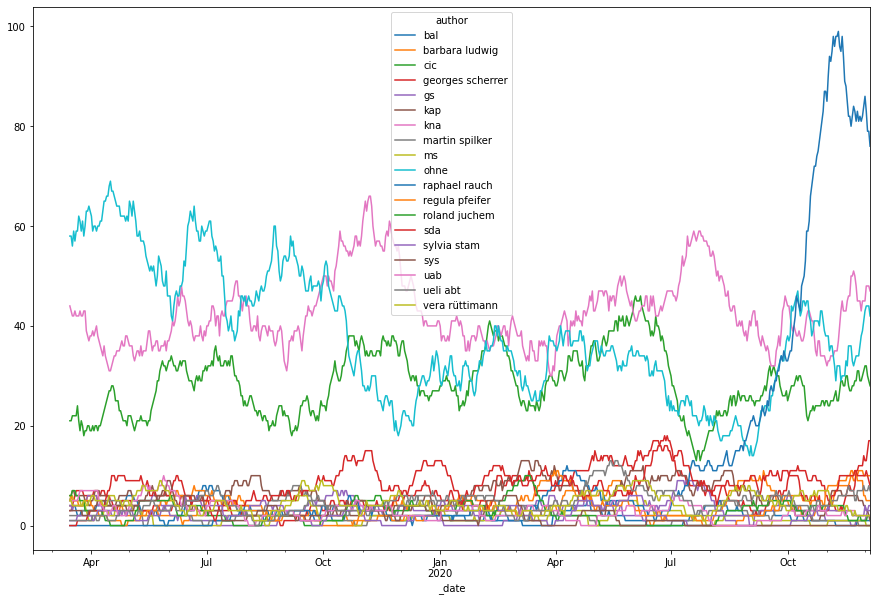

In [64]:
df_data = df.copy()

df_data['author'] = df_data['author'].fillna('ohne')

# Lower Case
df_data['author'] = df_data['author'].str.lower()

# Join
df_data = df_data.merge(df_top, how='left', on='author')
df_data['top'] = df_data['top'].fillna(False)

# Only top authors
df_data = df_data[df_data.top]

# Add Agency
df_data['agency'] = df_data['author'].apply(lambda x: x in agencies)
#df_data = df_data[df_data.agency == False]

#df_data = df_data[df_data.author != 'raphael rauch']

# Set date
df_data['_date'] = df_data['date'].dt.date
df_data['_date'] = pd.to_datetime(df_data['_date'])

#df_data = df_data[['_date', 'author', 'title']]

gr = pd.pivot_table(df_data, index='_date', columns='author', values='title', aggfunc='count')
gr = gr.fillna(0)

# Add Rolling AVG
gr = gr.apply(lambda col: col.rolling(30).sum(), axis = 0)

gr.plot.line()

#df_data.groupby('author').count()



## Kategorie Type

<AxesSubplot:xlabel='_date'>

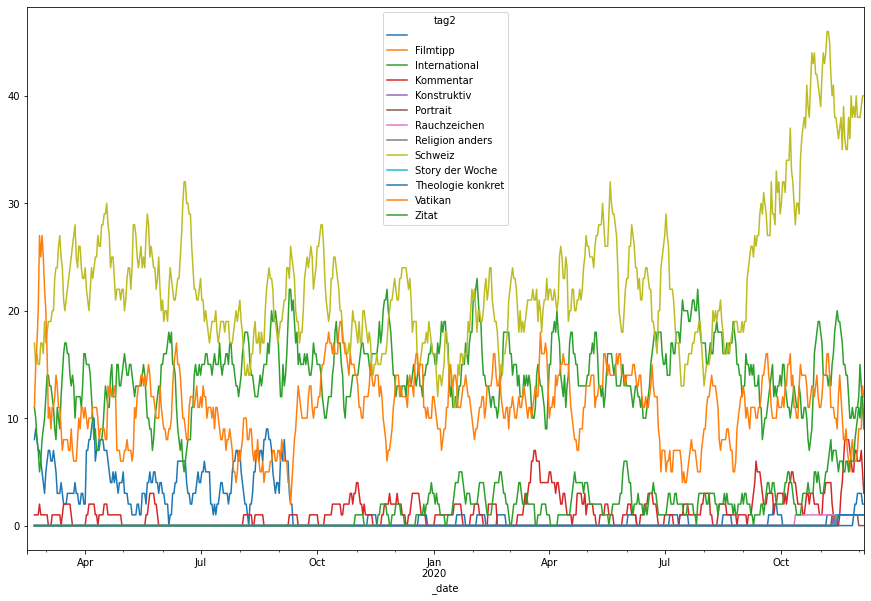

In [65]:
df_data = df.copy()

# Set date
df_data['_date'] = df_data['date'].dt.date
df_data['_date'] = pd.to_datetime(df_data['_date'])


gr = pd.pivot_table(df_data, index='_date', columns='tag2', values='title', aggfunc='count')
gr = gr.fillna(0)

# Add Rolling AVG
gr = gr.apply(lambda col: col.rolling(7).sum(), axis = 0)

gr.plot.line()

<AxesSubplot:xlabel='_date'>

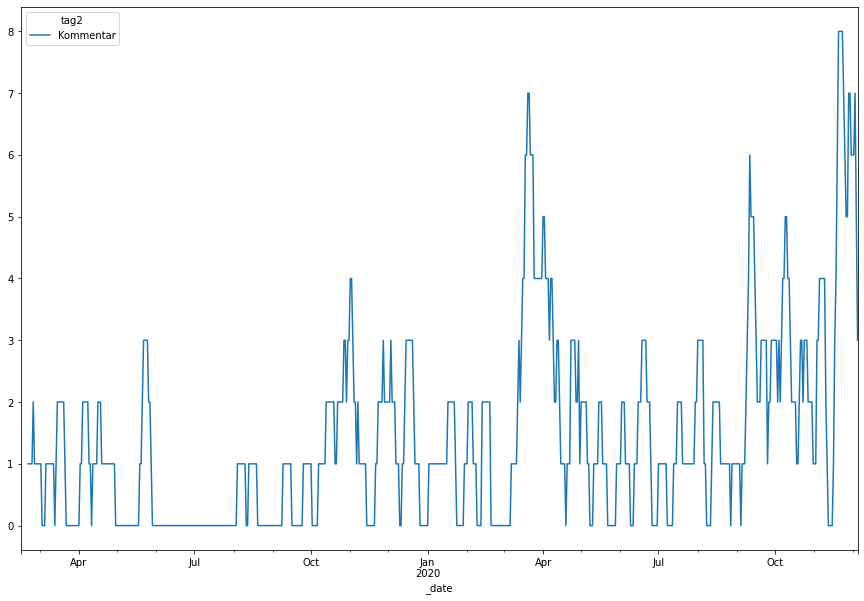

In [66]:
gr[['Kommentar']].plot.line()

## Was schreibt Rauch?

<AxesSubplot:xlabel='tag2'>

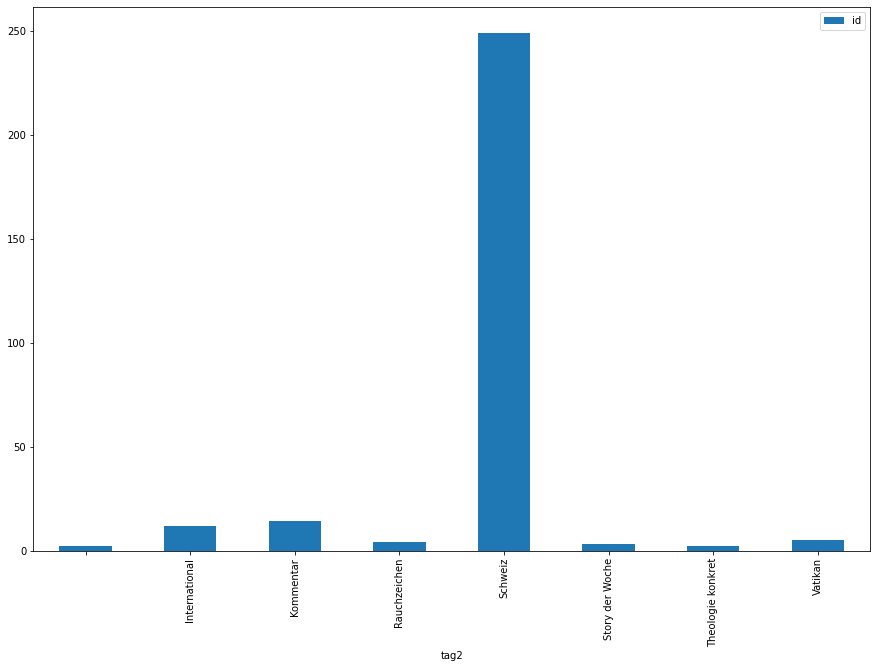

In [68]:
df_data = df.copy()

df_data['author'] = df_data['author'].str.lower()

df_data = df_data[df_data.author == 'raphael rauch']

# Group Category
df_data.groupby('tag2').agg({'id': 'count'}).plot.bar()



## Occurence of "Chur", etc

<AxesSubplot:xlabel='_date'>

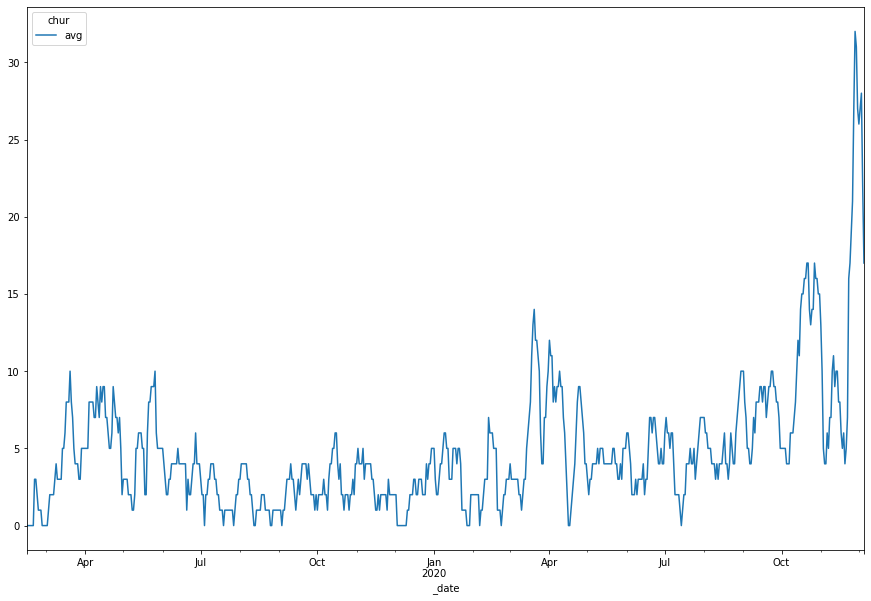

In [69]:
# Wordlist
wordlist = ['chur', 'grichting', 'huonder', 'domkapitel']

df_data = df.copy()

# Set date
df_data['_date'] = df_data['date'].dt.date
df_data['_date'] = pd.to_datetime(df_data['_date'])

# Add Chur
df_data['chur'] = df_data.text.apply(lambda x: any(s.lower() in x.lower() for s in wordlist))

# Select Only Chur
#df_data = df_data[df_data.chur]

# Group by
gr = pd.pivot_table(df_data, index='_date', values='id', columns = 'chur', aggfunc = 'count')

gr[True] = gr[True].fillna(0)

gr = gr.drop(columns=[False])

# Add Rolling AVG
gr['avg'] = gr[True].rolling(7).sum()#apply(lambda x: x.rolling(7).sum())
gr['avg'] = gr['avg'].fillna(0)

#gr.plot()
gr[['avg']].plot()

## Extract Rauch Texts

In [71]:
df_data = df.copy()

df_data['url'] = df_data['id'].apply(lambda x: 'https://www.kath.ch/newsd/%s/' % x)

df_data[df_data.author.str.lower() == 'raphael rauch'].sort_values('date').to_csv('rauch.csv', sep = ';', encoding='UTF-8')


## Others

In [35]:
df_data = df.copy()

df_data['url'] = df_data['id'].apply(lambda x: 'https://www.kath.ch/newsd/%s/' % x)

df_data[df_data.author.isna()].sort_values('date', ascending=False).head(50).to_csv('noauthor.csv', sep = ';')